### Evaluation and Serving of the LSTM model with attention
This script demonstrates the process of evaluating, and serving an LSTM model with attention for intent classification on the ATIS dataset. It encapsulates key stages of the machine learning workflow, including data preprocessing, model training, performance evaluation, and prediction. The modular structure facilitates easy experimentation with different models and datasets.

In [1]:
import pandas as pd
import torch
from machine_learning.IntentTokenizer import IntentTokenizer
from machine_learning.model_utils import train, evaluate, predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Determine the computation device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")


Using device: mps


#### Load the tokenized and test datasets

In [3]:
# Specify the model name for loading
model_name = "best_ICELSTMAmodel"

# Load the trained model and tokenizer from saved files
model_serve = torch.load(f"models/{model_name}.pth").to(device)
tokenizer = tokenizer = IntentTokenizer.load_state(IntentTokenizer,f"models/{model_name}_tokenizer.pickle", f"models/IntentClassifierLSTMWithAttention_le.pickle")
# Load the test dataset for evaluation
test_df = pd.read_csv('data/atis/test.tsv', sep='\t', header=None, names=["text", "label"])

#### Evaluate the model on the test dataset
The following methods are used for evaluation:
- Accuracy
- Precision
- Recall
- F1 Score
- Confusion Matrix
- Precision-Recall Curve
- ROC Curve
- Classification Report

In [4]:
# Extract true labels from the test data
y_test = test_df['label'].values

# Predict labels using the trained model
y_pred = predict(model_serve, test_df, tokenizer, device)

# Compute accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Display the computed metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Detailed classification report
print(classification_report(y_test, y_pred))

tensor([[ 10,  37,  25,  ...,   0,   0,   0],
        [  5, 238,  40,  ...,   0,   0,   0],
        [  5, 238,  40,  ...,   0,   0,   0],
        ...,
        [ 10,  47,  25,  ...,   0,   0,   0],
        [ 10,  37,  25,  ...,   0,   0,   0],
        [ 92,   8,  14,  ...,   0,   0,   0]], device='mps:0')
Accuracy: 0.9623529411764706
Precision: 0.9622208692698067
Recall: 0.9623529411764706
F1 Score: 0.9599560750752281
                   precision    recall  f1-score   support

     abbreviation       1.00      0.92      0.96        26
         aircraft       1.00      0.75      0.86         8
          airfare       0.96      0.98      0.97        48
   airfare+flight       0.00      0.00      0.00         1
          airline       1.00      0.96      0.98        28
airline+flight_no       0.00      0.00      0.00         0
          airport       1.00      0.77      0.87        13
         capacity       1.00      0.95      0.98        21
             city       1.00      0.80      0.8

#### Visualize the confusion matrix


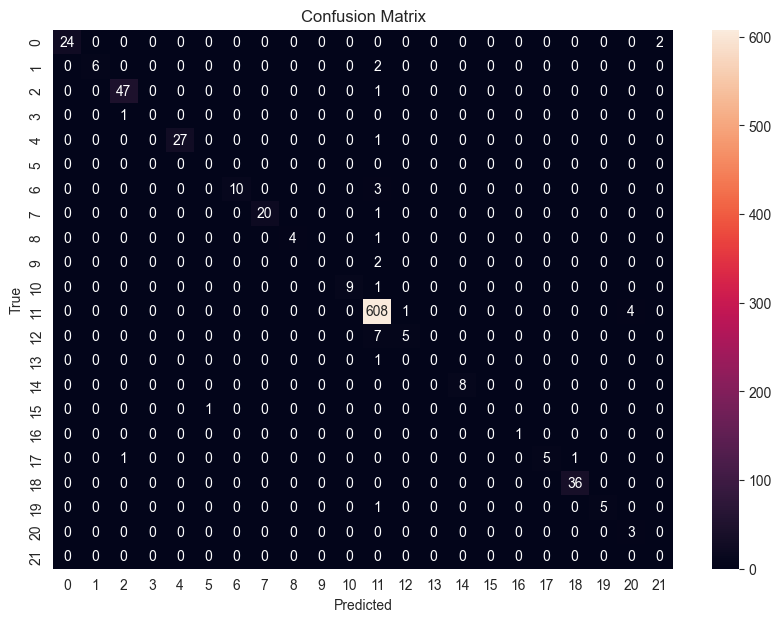

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#### Visualize the precision-recall curve and ROC curve

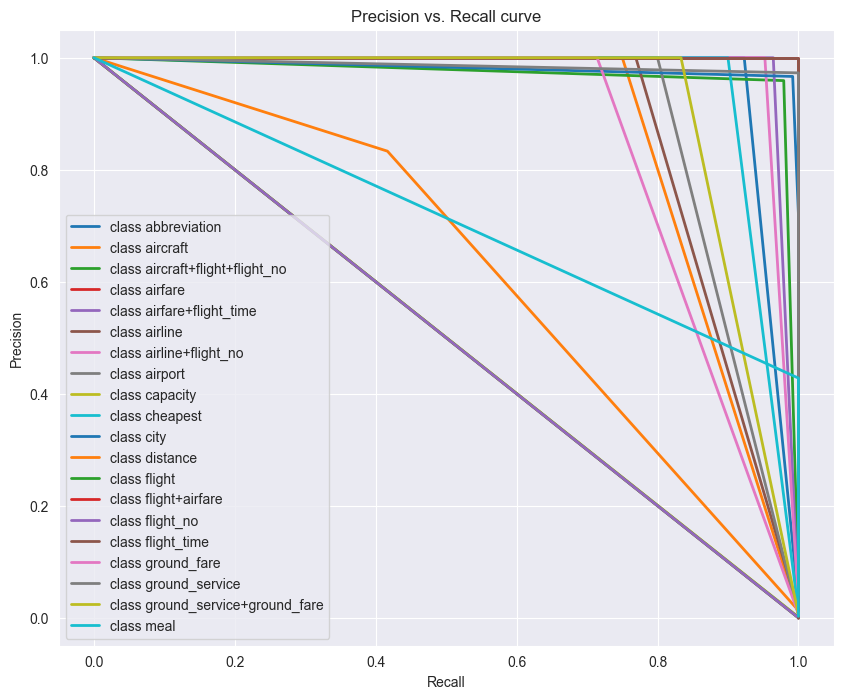

In [6]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class plots
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
y_pred_binarized = label_binarize(y_pred, classes=np.unique(y_test))

n_classes = y_test_binarized.shape[1]

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(recall, precision, lw=2, label=f'class {tokenizer.le.classes_[i]}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best")
plt.title("Precision vs. Recall curve")
plt.show()

### Visualize ROC curve

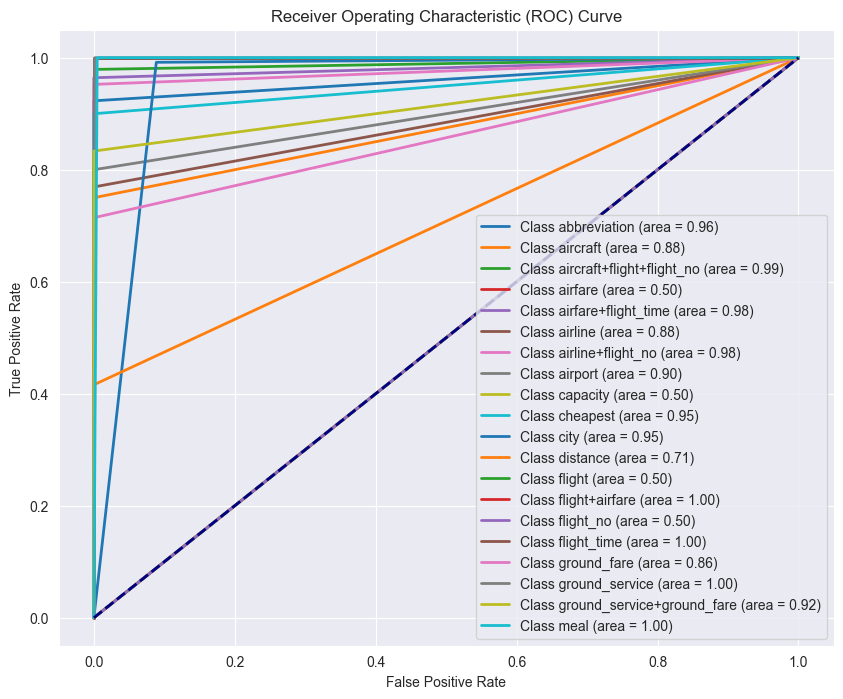

In [7]:

from sklearn.metrics import roc_curve, auc

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {tokenizer.le.classes_[i]} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()